In [1]:
import sys
import os
import ast
import hashlib
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import pandas as pd
import pymysql
import cv2
from PIL import Image
import scipy.fftpack
from itertools import combinations
import networkx as nx
from sklearn.model_selection import train_test_split
from tqdm.contrib.concurrent import process_map
from matplotlib import pyplot as plt

load_dotenv(verbose=False)

# Need to be changed to your locals
bucket_dir = 's3://aisle3-ml-datasets/arcface/'
data_dir = Path(os.getenv("DATA_DIR"))
images_dir = Path(os.getenv("IMG_DIR"))

idx = pd.IndexSlice
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

poses_to_retain = ['upper_shot',
                   '3qrt_shot',
                   'side_shot',
                   'pair_shot']

##  Load datasets

In [2]:
%%time
def fetch_table_data(query):
    """Fetch a MySQL table with a `query` as a `pandas.DataFrame`.

    Args:
        query (str): SQL query to be executed.

    Returns:
        table_df (pandas.DataFrame): Fetched table.
    """
    # Create a connectable object to the MySQL server.
    connection = pymysql.connect(host=os.getenv("DB_HOST"),
                                 user=os.getenv("DB_USERNAME"),
                                 password=os.getenv("DB_PASSWORD"),
                                 database=os.getenv("DB_DATABASE"),
                                 port=int(os.getenv("DB_PORT")),
                                 charset="utf8mb4",
                                 cursorclass=pymysql.cursors.DictCursor)

    # Fetch table data into a pandas.DataFrame.
    table_df = pd.read_sql(query,
                           con=connection)

    # Close the MySQL server connection.
    connection.close()

    return table_df

# Fetch products table and normalize brands for blocking
products_qry = f"""
    SELECT
        id as product_id,
        a3_prod_id as variant_id,
        name,
        merchant,
        brand,
        property->>"$.gender" as gender,
        property->>"$.colour" as colour
    FROM
        offers_en_new
    """
products = fetch_table_data(products_qry)
brand_norm_map = pd.read_csv("s3://aisle3-ml-datasets/arcface/brands_normalization.csv")
brand_norm_map = dict(brand_norm_map.values)
print(f'Unique brands: {products.brand.nunique()}')
products.brand = products.brand.str.lower().str.strip().replace(brand_norm_map)
print(f'Unique brands after normalization: {products.brand.nunique()}')

# Fetch images table and get images paths (already synched to images_dir)
images_qry = f"""
    SELECT
        product_id,
        image_url
    FROM
        images_en_new
    """
images_meta = fetch_table_data(images_qry)

images_meta['image_path'] = images_meta.image_url.apply(lambda x:
                                                        "/".join(x.split('/')[-3:]))
poses = pd.read_csv(bucket_dir + 'poses.csv', index_col='id')
images_meta = images_meta.merge(poses[['image_path', 'pose_predictions']],
                                on='image_path')
del images_meta['image_url']
# Fetch hand annotated data and gold annotations
matched_annotations_qry = f"""
    SELECT
        offer_id as source,
        matched_offer_id as target,
        is_match as 'match'
    FROM
        matched_arcface_offers_en
    """
gold_annotations_qry = f"""
    SELECT
        source,
        target
    FROM
        gold_annotations
    """
gold_annotations = fetch_table_data(gold_annotations_qry)
gold_ids = np.unique(gold_annotations[['source', 'target']].
                     values.reshape(-1, 1))

matched_annotations = fetch_table_data(matched_annotations_qry)
matched_ids = np.unique(matched_annotations[['source', 'target']]
                        .values.reshape(-1, 1))

gold_not_product = np.setdiff1d(gold_ids, products.product_id.values)
print(f'Gold IDs not in product IDs: {len(gold_not_product)}')

gold_annotations = gold_annotations[~gold_annotations[['source', 'target']].
                                    isin(gold_not_product).any(axis=1)]
matched_annotations = matched_annotations[matched_annotations.match == 1][['source', 'target']]

matched_annotations = pd.concat([gold_annotations, matched_annotations])
matched_annotations.drop_duplicates(inplace=True)
matched_annotations.reset_index(drop=True, inplace=True)

def matched_graph(matches):
    """Get the connected components of the graph determined by `matches`.

    Args:
        matches (pandas.DataFrame): DataFrame of source and target matches.

    Returns:
        matches_cc_graph (networkx.Graph): Fully connected graph.
        matches_cc (dict): Dictionary keyed by connected component number
            and valued by list of nodes in component.
    """
    matched_pairs = matches.apply(tuple, axis=1)
    matches_graph = nx.Graph()
    matches_graph.add_edges_from(matched_pairs.to_list())
    matches_cc = list(nx.connected_components(matches_graph))
    matches_cc_edges = [combinations(c, 2) for c in matches_cc]
    matches_cc_edges = [e for ce in matches_cc_edges for e in ce]
    matches_cc_graph = nx.Graph()
    matches_cc_graph.add_edges_from(matches_cc_edges)
    matches_cc = [list(c) for c in  matches_cc]
    matches_cc = dict(zip(range(len(matches_cc)), matches_cc))
    return matches_cc_graph, matches_cc

matched_cc_graph, matched_cc = matched_graph(matched_annotations)
key_fill = len(str(len(matched_cc)))
matched_cc = {'matchedcc.' + str(k).zfill(key_fill): v for k, v in matched_cc.items()}
prod_cc_map = {i: k for k, v in matched_cc.items() for i in v}
images_meta['label'] = images_meta.product_id.map(prod_cc_map)

Unique brands: 1083
Unique brands after normalization: 999
Gold IDs not in product IDs: 163
CPU times: user 4.64 s, sys: 636 ms, total: 5.28 s
Wall time: 13.1 s


##  Perceptual hashing to handle duplicates and invalid images

In [3]:
white_hash = '-'.join([''.join(['8'] + ['0']*63)]*3)

def binary_to_hex(arr):
    bit_string = "".join(str(b) for b in 1 * arr.flatten())
    width = int(np.ceil(len(bit_string) / 4))
    return "{:0>{width}x}".format(int(bit_string, 2), width=width)

def hash_image(img_path,
               img_dir=images_dir,
               hash_size=16,
               highfreq_factor=4):
    
    img = cv2.imread(str(images_dir / img_path))
    try:
        img_size = hash_size * highfreq_factor
        img = cv2.resize(img, (img_size, img_size))
        img = np.asarray(img)
        channel_hashes = list()
        channels = [img[:, :, i] for i in range(img.shape[2])]
        for channel in channels:
            dct = scipy.fftpack.dct(scipy.fftpack.dct(channel, axis=0), axis=1)
            dctlowfreq = dct[:hash_size, :hash_size]
            med = np.median(dctlowfreq)
            diff = dctlowfreq > med
            channel_hashes.append(binary_to_hex(diff))
        img_hash =  "-".join(channel_hashes)
    except Exception:
        img_hash = white_hash
    return img_hash

phash = process_map(hash_image,
                    images_meta.image_path.to_list(),
                    max_workers=16,
                    chunksize=100)
phash = pd.Series(phash, index=images_meta.index)
phash_distr = phash.value_counts()
print(phash_distr.value_counts())

  0%|          | 0/200204 [00:00<?, ?it/s]

1      197870
2         815
3          14
4           8
353         1
158         1
70          1
21          1
13          1
10          1
5           1
dtype: int64


### Sample duplicated hashes

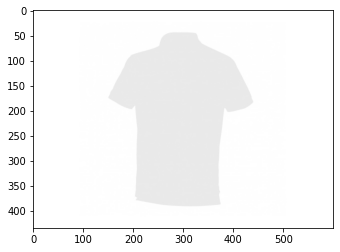

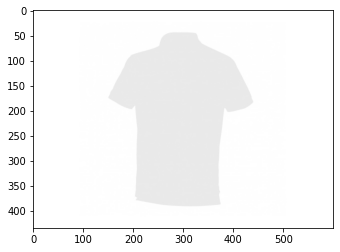

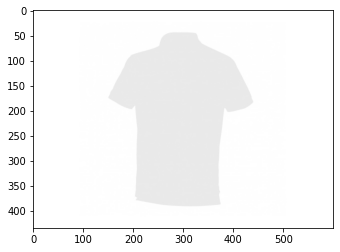

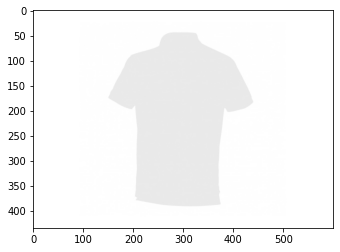

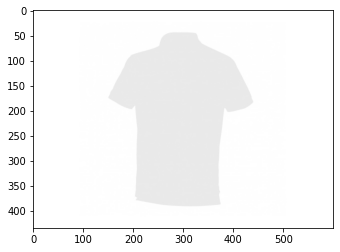

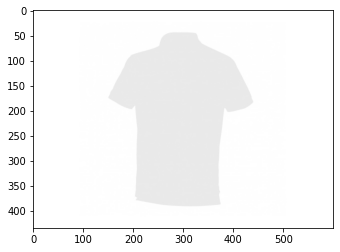

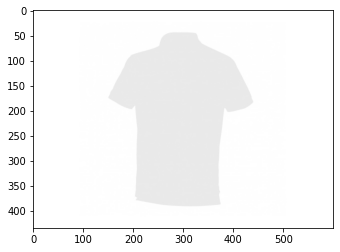

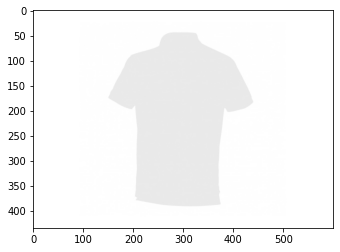

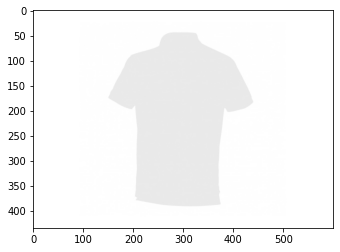

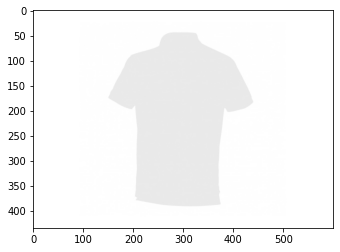

,product_id,variant_id,name,merchant,brand,gender,colour
13406,camper.gbKU10004001,camper.gbKU10004001,Camper T-Shirt K Tipologiaconsumidores_cst_t14...,Camper,camper,Unisex,Black
13407,camper.gbKU10004002,camper.gbKU10004001,Camper T-Shirt K Tipologiaconsumidores_cst_t14...,Camper,camper,Unisex,Blue
13408,camper.gbKU10004003,camper.gbKU10004001,Camper T-Shirt K Tipologiaconsumidores_cst_t14...,Camper,camper,Unisex,Burgundy
13409,camper.gbKU10004004,camper.gbKU10004001,Camper T-Shirt K Tipologiaconsumidores_cst_t14...,Camper,camper,Unisex,Black
13410,camper.gbKU10005001,camper.gbKU10005001,Camper Sweatshirt K Tipologiaconsumidores_cst_...,Camper,camper,Unisex,Black
13411,camper.gbKU10005002,camper.gbKU10005001,Camper Sweatshirt K Tipologiaconsumidores_cst_...,Camper,camper,Unisex,Burgundy
13412,camper.gbKU10006001,camper.gbKU10006001,Camper Hoodie K Tipologiaconsumidores_cst_t14 ...,Camper,camper,Unisex,Black
13413,camper.gbKU10006002,camper.gbKU10006001,Camper Hoodie K Tipologiaconsumidores_cst_t14 ...,Camper,camper,Unisex,Burgundy
13414,camper.gbKU10006003,camper.gbKU10006001,Camper Hoodie K Tipologiaconsumidores_cst_t14 ...,Camper,camper,Unisex,Black
13415,camper.gbKU10008001,camper.gbKU10008001,Camper Cap K Tipologiaconsumidores_cst_t14 unisex,Camper,camper,Unisex,Burgundy


In [6]:
hash_qry_idx = phash[phash == phash_distr.index[5]].index

hash_qry_paths_sample = images_meta.loc[hash_qry_idx, 'image_path'].sample(min(20, len(hash_qry_idx)))
for p in hash_qry_paths_sample:
    p = str(images_dir / p)
    img = Image.open(p)
    plt.imshow(img)
    plt.show()

products[products.product_id.isin(images_meta.loc[hash_qry_idx].product_id)]

### Filter invalid and "image not available" images out

This time these coincided with those with very frequent phashes.

In [7]:
white_hash_img_idx = phash[phash == white_hash].index
hash_nonavailable_img_idx = phash[phash.isin(phash_distr[phash_distr > 4].index)].index
hash_nonavailable_img_idx = hash_nonavailable_img_idx.union(white_hash_img_idx)
hash_available_img_idx = images_meta.index.difference(hash_nonavailable_img_idx)
images_meta = images_meta.loc[hash_available_img_idx]

###  Drop duplicated of non-annotated images

In [8]:
unlabelled_idx = images_meta[~images_meta.label.notnull()].index
unlabelled_phash = phash[unlabelled_idx]
unlabelled_dup_phash_idx = unlabelled_phash[unlabelled_phash.duplicated()].index
dropdup_idx = images_meta.index.difference(unlabelled_dup_phash_idx)
images_meta = images_meta.loc[dropdup_idx]

## Remove non-labeled product IDs with insufficient (less that 3) images 

In [9]:
unlabelled_idx = images_meta[~images_meta.label.notnull()].index
images_id_dist = images_meta.product_id.value_counts()
insuff_img_pids = images_id_dist[images_id_dist <= 3].index.unique()
insuff_img_pids_idx = images_meta[images_meta.product_id.isin(insuff_img_pids)].index
unlabelled_pids_idx = unlabelled_idx.intersection(insuff_img_pids_idx)
images_meta = images_meta.loc[images_meta.index.difference(unlabelled_pids_idx)]

## Select products from merchants with most brand values to fill label column with pids

In [10]:
cc_label_idx = images_meta[images_meta.label.notnull()].index
tofill_label_idx = images_meta[~images_meta.label.notnull()].index
tofill_master_pids = images_meta.loc[tofill_label_idx, 'product_id'].unique()
tofill_master_products = products[products.product_id.isin(tofill_master_pids)]

branch_merchant_cnts = tofill_master_products.groupby('brand').merchant.value_counts()
branch_top_merchant = branch_merchant_cnts.groupby(level='brand').head(1)

tofill_master_brand_merch = tofill_master_products[['brand', 'merchant']].apply(tuple, axis=1)
tofill_master_block_mask = tofill_master_brand_merch.isin(branch_top_merchant.index.values)
tofill_master_block_pids = tofill_master_products[tofill_master_block_mask].product_id

tofill_label_idx = images_meta.loc[images_meta.product_id.isin(tofill_master_block_pids)].index

label_idx = cc_label_idx.union(tofill_label_idx)
images_meta = images_meta.loc[label_idx]

images_meta.label.fillna(images_meta.product_id, inplace=True)

pid_label_map = images_meta[['product_id', 'label']].drop_duplicates()
pid_label_map = pid_label_map.set_index('product_id').label.to_dict()
products['label'] = products.product_id.map(pid_label_map)
products.dropna(inplace=True)

## Final dataset exploration

In [11]:
images_meta_matched = images_meta.loc[cc_label_idx]
images_meta_filled = images_meta.loc[tofill_label_idx]

matched_pids = images_meta_matched.product_id.unique()
filled_pids = images_meta_filled.product_id.unique()

products_matched = products[products.product_id.isin(matched_pids)]
products_filled = products[products.product_id.isin(filled_pids)]

print(f'Annotated data fraction: '
      f'{len(images_meta_matched)/len(images_meta):0.2%}')

Annotated data fraction: 2.19%


### Image samples

matchedcc.089
['jdsports.1267669' 'allsole.10993068' 'asos.1769099' 'asos.1480467'
 'asos.1576497' 'converse.132169C']


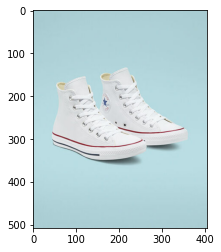

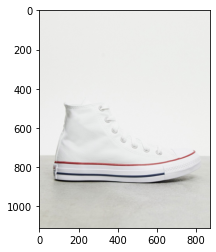

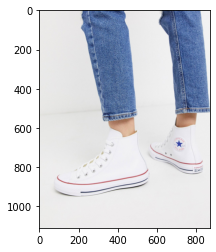

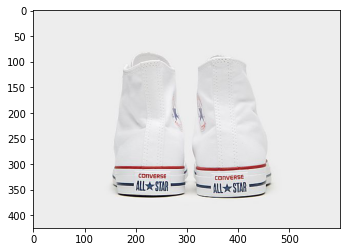

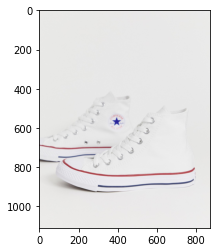

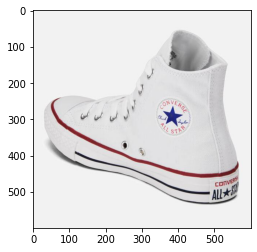

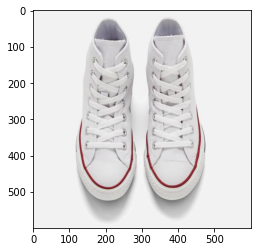

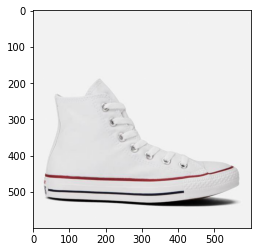

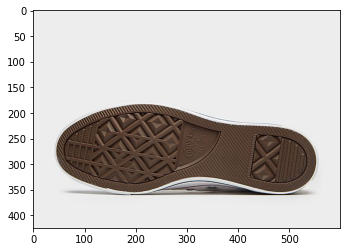

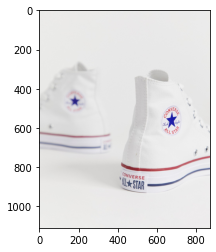

In [12]:
sample_label = np.random.choice(images_meta_matched.label.unique())
sample_meta = images_meta_matched[images_meta_matched.label == sample_label]
print(sample_label)
print(sample_meta.product_id.unique())
sample_paths = sample_meta.image_path
sample_paths = sample_paths.sample(min(10, len(sample_paths)))
for p in sample_paths:
    p = str(images_dir / p)
    img = Image.open(p)
    plt.imshow(img)
    plt.show()

endclothing.3095962806
['endclothing.3095962806']


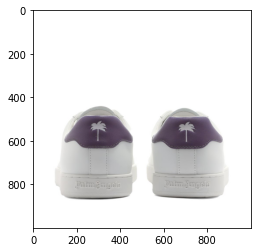

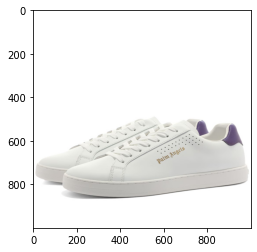

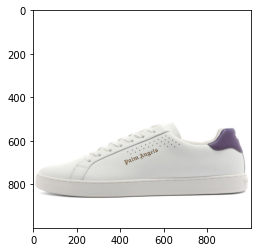

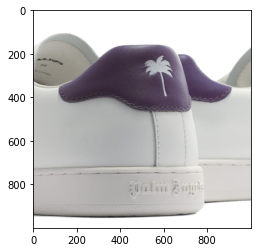

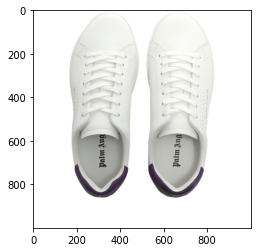

In [13]:
sample_label = np.random.choice(images_meta_filled.label.unique())
sample_meta = images_meta_filled[images_meta_filled.label == sample_label]
print(sample_label)
print(sample_meta.product_id.unique())
sample_paths = sample_meta.image_path
sample_paths = sample_paths.sample(min(10, len(sample_paths)))
for p in sample_paths:
    p = str(images_dir / p)
    img = Image.open(p)
    plt.imshow(img)
    plt.show()

### Image and product id counts

In [14]:
print('Total annotated images: \n',
      len(images_meta_matched))
print('Image counts per annotated label: \n',
      images_meta_matched.groupby('label').image_path.count().value_counts())
print('Annotated total product ids: \n',
      len(matched_pids))
print('Product id counts per annotated label: \n',
      images_meta_matched.groupby('label').product_id.unique().apply(len).value_counts())

Total annotated images: 
 2376
Image counts per annotated label: 
 8     106
10     60
12     16
9      12
6       7
7       5
13      4
18      4
16      4
4       3
14      3
15      2
19      2
5       2
38      1
28      1
30      1
21      1
22      1
20      1
11      1
23      1
36      1
2       1
Name: image_path, dtype: int64
Annotated total product ids: 
 547
Product id counts per annotated label: 
 2    200
3     24
4     11
5      2
6      2
9      1
Name: product_id, dtype: int64


In [15]:
print('Filled label total images: \n',
      len(images_meta_filled))
print('Image counts per filled label: \n',
      images_meta_filled.groupby('label').image_path.count().value_counts())
print('Total filled product ids: \n',
      len(filled_pids))

Filled label total images: 
 106040
Image counts per filled label: 
 4     14848
5      4185
6      2774
7       467
8       292
9       271
10       57
11       22
12       14
14        3
13        1
Name: image_path, dtype: int64
Total filled product ids: 
 22934


### Brand and merchant distribution

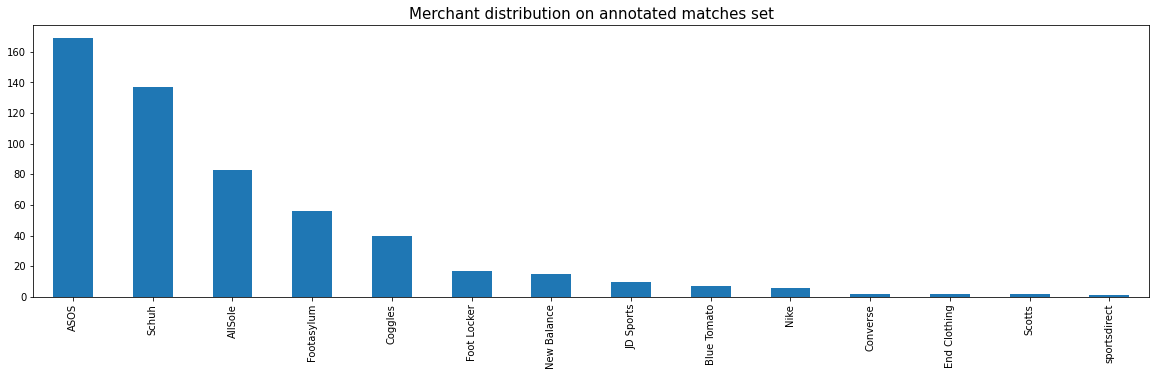

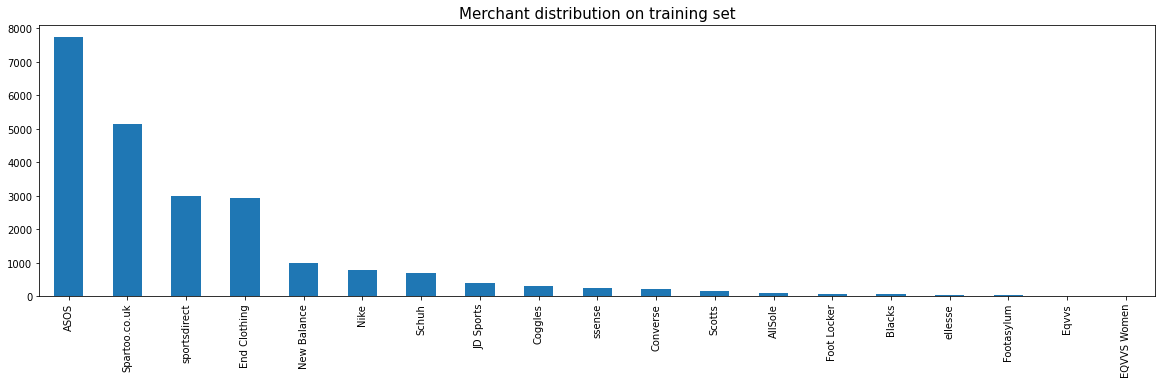

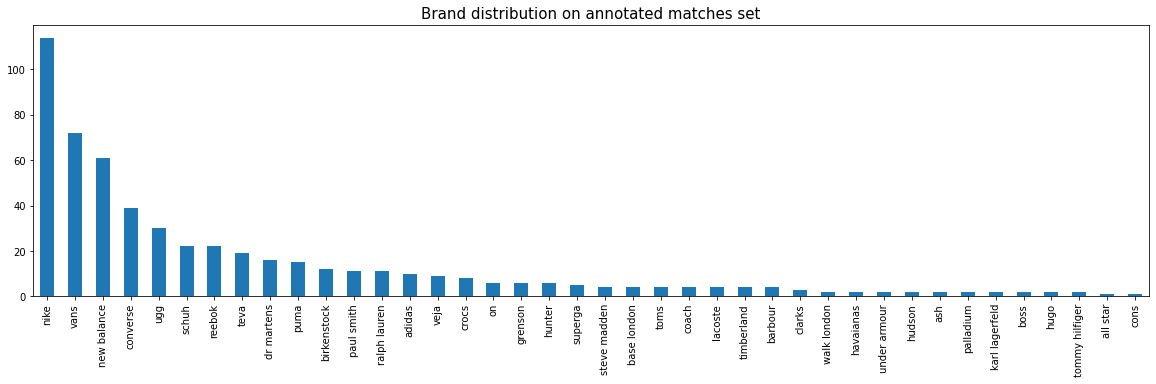

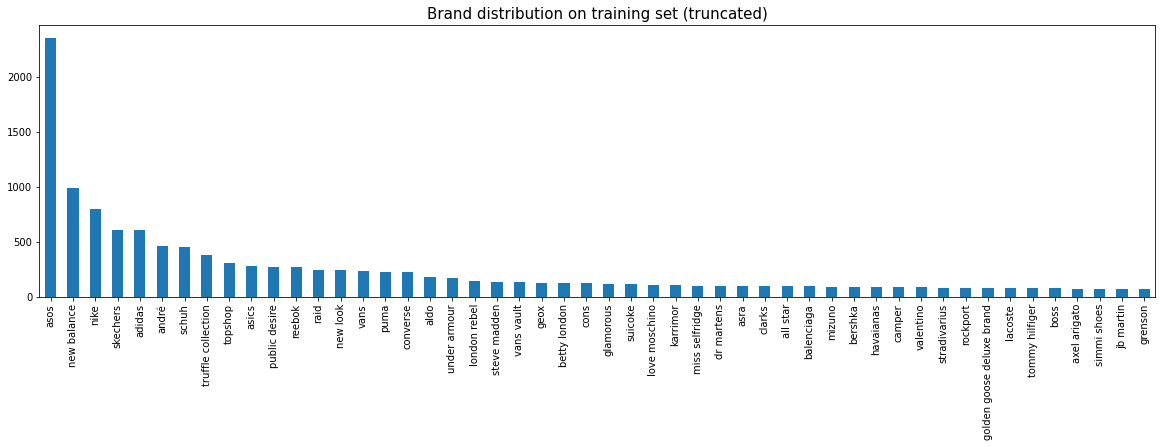

In [16]:
products_matched.merchant.value_counts().plot.bar(figsize=(20,5))
plt.title('Merchant distribution on annotated matches set', {'fontsize': 15});
plt.show()
products_filled.merchant.value_counts().plot.bar(figsize=(20,5))
plt.title('Merchant distribution on training set', {'fontsize': 15});
plt.show()
products_matched.brand.value_counts().plot.bar(figsize=(20,5))
plt.title('Brand distribution on annotated matches set', {'fontsize': 15});
plt.show()
products_filled.brand.value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Brand distribution on training set (truncated)', {'fontsize': 15});

##  Training and Dev set generation

In [17]:
images_meta_train, images_meta_dev = train_test_split(images_meta_filled,
                                                      stratify=images_meta_filled.label,
                                                      test_size=0.25,
                                                      random_state=101)
images_meta_train.sort_index(inplace=True)
images_meta_dev.sort_index(inplace=True)

In [18]:
print('Training total images: \n',
      len(images_meta_train))
print('Training image counts per label: \n',
      images_meta_train.groupby('label').image_path.count().value_counts())
print('Training total product ids: \n',
      len(images_meta_train.product_id.unique()))

Training total images: 
 79530
Training image counts per label: 
 3     14848
4      6541
5       885
7       321
6       292
8        29
9        14
10        4
Name: image_path, dtype: int64
Training total product ids: 
 22934


In [19]:
print('Validation total images: \n',
      len(images_meta_dev))
print('Validation image counts per label: \n',
      images_meta_dev.groupby('label').image_path.count().value_counts())
print('Validation total product ids: \n',
      len(images_meta_dev.product_id.unique()))

Validation total images: 
 26510
Validation image counts per label: 
 1    19451
2     3393
3       87
4        3
Name: image_path, dtype: int64
Validation total product ids: 
 22934


In [20]:
product_cols = ['product_id',
                'variant_id',
                'name',
                'merchant',
                'brand',
                'gender']

images_train = images_meta_train.merge(products_filled[product_cols],
                                       on='product_id')
images_dev = images_meta_dev.merge(products_filled[product_cols],
                                   on='product_id')
images_eval = images_meta_matched.merge(products_matched[product_cols],
                                        on='product_id')

images_train.index = images_meta_train.index
images_dev.index = images_meta_dev.index
images_eval.index = images_meta_matched.index

In [19]:
images_meta_train.to_csv(data_dir / 'images_meta_train.csv', index_label='id')
images_meta_dev.to_csv(data_dir / 'images_meta_dev.csv', index_label='id')
products_filled.to_csv(data_dir / 'products_train.csv', index_label='id')
images_meta_matched.to_csv(data_dir / 'images_meta_eval.csv', index_label='id')
products_matched.to_csv(data_dir / 'products_eval.csv', index_label='id')

images_meta_train.to_csv(bucket_dir + 'images_meta_train.csv', index_label='id')
images_meta_dev.to_csv(bucket_dir + 'images_meta_dev.csv', index_label='id')
products_filled.to_csv(bucket_dir + 'products_train.csv', index_label='id')
images_meta_matched.to_csv(bucket_dir + 'images_meta_eval.csv', index_label='id')
products_matched.to_csv(bucket_dir + 'products_eval.csv', index_label='id')

images_train.to_csv(data_dir /'images_train.csv', index_label='id')
images_dev.to_csv(data_dir /'images_dev.csv', index_label='id')
images_eval.to_csv(data_dir /'images_eval.csv', index_label='id')

images_train.to_csv(bucket_dir + 'images_train.csv', index_label='id')
images_dev.to_csv(bucket_dir + 'images_dev.csv', index_label='id')
images_eval.to_csv(bucket_dir + 'images_eval.csv', index_label='id')